In [1]:
import uproot
import awkward as ak
from coffea import nanoevents
from coffea.nanoevents.methods.base import NanoEventsArray

import pickle
import numpy as np

from typing import Optional, List, Dict
from copy import copy

import matplotlib.pyplot as plt
import mplhep as hep
from matplotlib import colors

from tqdm import tqdm
import fastjet
import jetnet
import vector

import os

In [2]:
plot_dir = "../../../plots/ScaleFactors/Oct20/"
_ = os.system(f"mkdir -p {plot_dir}")

In [3]:
events = nanoevents.NanoEventsFactory.from_root(
    "/eos/uscms/store/user/lpcpfnano/cmantill/v2_3/2017/HH_gen/GluGluToHHTobbVV_node_cHHH1_TuneCP5_13TeV-powheg-pythia8/GluGluToHHTobbVV_node_cHHH1/221017_221918/0000/nano_mc2017_100.root",
    schemaclass=nanoevents.NanoAODSchema,
).events()


/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15SubJet_nBHadrons in <TTree 'Events' (1994 branches) at 0x7ff3575d33a0>, taking first instance
  warnings.warn(
/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15SubJet_nCHadrons in <TTree 'Events' (1994 branches) at 0x7ff3575d33a0>, taking first instance
  warnings.warn(
/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15_nBHadrons in <TTree 'Events' (1994 branches) at 0x7ff3575d33a0>, taking first instance
  warnings.warn(
/uscms_data/d3/rkansal/mambaforge/envs/python39/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:75: UserWarning: Found duplicate branch FatJetAK15_nCHadrons in <TTree 'Eve

### Boosted Pre-selection

In [5]:
def pad_val(
    arr: ak.Array,
    target: int,
    value: float,
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=None)
    return ret.to_numpy() if to_numpy else ret


preselection_cut_vals = {"pt": 250, "msd": 20}
num_jets = 2

preselection_cut = np.prod(
    pad_val(
        (events.FatJet.pt > preselection_cut_vals["pt"])
        * (events.FatJet.msoftdrop > preselection_cut_vals["msd"]),
        num_jets,
        False,
        axis=1,
    ),
    axis=1,
).astype(bool)

presel_events = events[preselection_cut]


### Gen Selection

In [26]:
d_PDGID = 1
b_PDGID = 5
g_PDGID = 21
TOP_PDGID = 6

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

Z_PDGID = 23
W_PDGID = 24
HIGGS_PDGID = 25

b_PDGIDS = [511, 521, 523]

GRAV_PDGID = 39

GEN_FLAGS = ["fromHardProcess", "isLastCopy"]

FILL_NONE_VALUE = -99999


skim_vars = {
    "eta": "eta",
    "phi": "phi",
    "mass": "mass",
    "pt": "pt",
}

# finding the two gen higgs
higgs = presel_events.GenPart[
    (abs(presel_events.GenPart.pdgId) == HIGGS_PDGID) * presel_events.GenPart.hasFlags(GEN_FLAGS)
]

# saving 4-vector info
GenHiggsVars = {f"GenHiggs{key}": higgs[var].to_numpy() for (var, key) in skim_vars.items()}

higgs_children = higgs.children

# saving whether H->bb or H->VV
GenHiggsVars["GenHiggsChildren"] = abs(higgs_children.pdgId[:, :, 0]).to_numpy()

# finding bb and VV children
is_bb = abs(higgs_children.pdgId) == b_PDGID
is_VV = (abs(higgs_children.pdgId) == W_PDGID) + (abs(higgs_children.pdgId) == Z_PDGID)

# checking that there are 2 b's and 2 V's
has_bb = ak.sum(ak.flatten(is_bb, axis=2), axis=1) == 2
has_VV = ak.sum(ak.flatten(is_VV, axis=2), axis=1) == 2

# only select presel_events with 2 b's and 2 V's
# add_selection("has_bbVV", has_bb * has_VV, selection, cutflow, False, signGenWeights)

# saving bb and VV 4-vector info
bb = ak.flatten(higgs_children[is_bb], axis=2)
VV = ak.flatten(higgs_children[is_VV], axis=2)

# have to pad to 2 because of some 4V presel_events
GenbbVars = {
    f"Genbb{key}": pad_val(bb[var], 2, FILL_NONE_VALUE, axis=1) for (var, key) in skim_vars.items()
}

# selecting only up to the 2nd index because of some 4V presel_events
# (doesn't matter which two are selected since these presel_events will be excluded anyway)
GenVVVars = {f"GenVV{key}": VV[var][:, :2].to_numpy() for (var, key) in skim_vars.items()}

# checking that each V has 2 q children
VV_children = VV.children

quarks = abs(VV_children.pdgId) <= b_PDGID
all_q = ak.all(ak.all(quarks, axis=2), axis=1)
# add_selection("all_q", all_q, selection, cutflow, False, signGenWeights)

V_has_2q = ak.count(VV_children.pdgId, axis=2) == 2
has_4q = ak.values_astype(ak.prod(V_has_2q, axis=1), bool)
# add_selection("has_4q", has_4q, selection, cutflow, False, signGenWeights)

# saving 4q 4-vector info
Gen4qVars = {
    f"Gen4q{key}": ak.to_numpy(
        ak.fill_none(
            ak.pad_none(ak.pad_none(VV_children[var], 2, axis=1, clip=True), 2, axis=2, clip=True),
            FILL_NONE_VALUE,
        )
    )
    for (var, key) in skim_vars.items()
}

gen_cut = has_bb * has_VV * all_q * has_4q
gen_vars = {**GenHiggsVars, **GenbbVars, **GenVVVars, **Gen4qVars}

sel_events = presel_events[gen_cut]
gen_vars = {key: np.squeeze(np.array(value[gen_cut])) for (key, value) in gen_vars.items()}

is_VV = abs(gen_vars["GenHiggsChildren"] == W_PDGID) + abs(gen_vars["GenHiggsChildren"] == Z_PDGID)


Gen vectors

In [44]:
genHWW = vector.Array(
    {
        "eta": gen_vars["GenHiggseta"][is_VV],
        "phi": gen_vars["GenHiggsphi"][is_VV],
        "pt": gen_vars["GenHiggspt"][is_VV],
        "mass": gen_vars["GenHiggsmass"][is_VV],
    }
)

gen4q = vector.array(
    {
        "eta": gen_vars["Gen4qeta"],
        "phi": gen_vars["Gen4qphi"],
        "pt": gen_vars["Gen4qpt"],
        "mass": gen_vars["Gen4qmass"],
    }
)

num_events = 5
gencands = vector.Array(sel_events.GenCands)[:num_events]

# fastjet doesn't accept vectors
gencands_arrays = [
    ak.zip(
        {"px": gencands[i].px, "py": gencands[i].py, "pz": gencands[i].pz, "E": gencands[i].E},
        with_name="Momentum4D",
    )
    for i in range(num_events)
]

In [71]:
# jet definitions
dR = 0.8
ak8def = fastjet.JetDefinition(fastjet.antikt_algorithm, dR)
cadef = fastjet.JetDefinition(fastjet.cambridge_algorithm, dR)
ktdef = fastjet.JetDefinition(fastjet.kt_algorithm, dR)
min_pt = 250
prong_dR = 1.5


In [80]:
matched_jets = []
matched_constituents = []
ca_W_subjet_constituents = []
ca_W_subjets = []
ca_q_subjet_constituents = []
ca_q_subjets = []
kt_W_subjet_constituents = []
kt_W_subjets = []
kt_q_subjet_constituents = []
kt_q_subjets = []

for i in tqdm(range(num_events)):
    # cluster into AK8 jets
    cluster = fastjet.ClusterSequence(gencands_arrays[i], ak8def)
    incl_jets = cluster.inclusive_jets(min_pt)

    # match jets with gen HWW
    jet_vectors = vector.Array(incl_jets)
    matched_HWW = jet_vectors.deltaR(genHWW[i]) < dR
    assert np.sum(matched_HWW) == 1, f"Matching issue in event {i}"

    # save matched jet and jet constituents
    matched_jets.append(jet_vectors[matched_HWW][0])
    matched_constituents_idx = cluster.constituent_index(min_pt)[matched_HWW][0]
    matched_constituents.append(gencands[i][matched_constituents_idx])


    # now re-clustering jet with C/A to get subjets:
    # need to convert into PseudoJets to get constituents
    # https://github.com/scikit-hep/fastjet/discussions/100 
    pseudojet_HWW = [
        fastjet.PseudoJet(
            gencands[i][idx].px, gencands[i][idx].py, gencands[i][idx].pz, gencands[i][idx].E
        )
        for idx in matched_constituents_idx
    ]

    cacluster = fastjet.ClusterSequence(pseudojet_HWW, cadef)

    # 2 subjets for 2 Ws
    excl_subjets = cacluster.exclusive_subjets(cacluster.inclusive_jets()[0], 2)
    ca_W_subjets.append(excl_subjets)

    subjet_consts = []

    # save constituents as vector array
    for j in range(2):
        consts = excl_subjets[j].constituents()
        consts_arrays = vector.array(
            {
                "px": [const.px() for const in consts], 
                "py": [const.py() for const in consts], 
                "pz": [const.pz() for const in consts], 
                "E": [const.E() for const in consts], 
            }
        )
        subjet_consts.append(consts_arrays)

    ca_W_subjet_constituents.append(subjet_consts)
    
    # Check how many prongs for quark subjets
    num_prongs = np.sum(genHWW[i].deltaR(gen4q[i]) < prong_dR)

    if num_prongs == 2:
        ca_q_subjet_constituents.append(subjet_consts)
        continue

    excl_subjets = cacluster.exclusive_subjets(cacluster.inclusive_jets()[0], int(num_prongs))
    ca_q_subjets.append(excl_subjets)
    subjet_consts = []
    
    # save constituents as vector array
    for j in range(num_prongs):
        consts = excl_subjets[j].constituents()
        consts_arrays = vector.array(
            {
                "px": [const.px() for const in consts], 
                "py": [const.py() for const in consts], 
                "pz": [const.pz() for const in consts], 
                "E": [const.E() for const in consts], 
            }
        )
        subjet_consts.append(consts_arrays)

    ca_q_subjet_constituents.append(subjet_consts)


    # re-doing with kT

    ktcluster = fastjet.ClusterSequence(pseudojet_HWW, ktdef)

    # 2 subjets for 2 Ws
    excl_subjets = ktcluster.exclusive_subjets(ktcluster.inclusive_jets()[0], 2)
    kt_W_subjets.append(excl_subjets)

    subjet_consts = []

    # save constituents as vector array
    for j in range(2):
        consts = excl_subjets[j].constituents()
        consts_arrays = vector.array(
            {
                "px": [const.px() for const in consts], 
                "py": [const.py() for const in consts], 
                "pz": [const.pz() for const in consts], 
                "E": [const.E() for const in consts], 
            }
        )
        subjet_consts.append(consts_arrays)

    kt_W_subjet_constituents.append(subjet_consts)
    
    # Check how many prongs for quark subjets
    num_prongs = np.sum(genHWW[i].deltaR(gen4q[i]) < prong_dR)

    if num_prongs == 2:
        kt_q_subjet_constituents.append(subjet_consts)
        continue

    excl_subjets = ktcluster.exclusive_subjets(ktcluster.inclusive_jets()[0], int(num_prongs))
    kt_q_subjets.append(excl_subjets)

    subjet_consts = []
    
    # save constituents as vector array
    for j in range(num_prongs):
        consts = excl_subjets[j].constituents()
        consts_arrays = vector.array(
            {
                "px": [const.px() for const in consts], 
                "py": [const.py() for const in consts], 
                "pz": [const.pz() for const in consts], 
                "E": [const.E() for const in consts], 
            }
        )
        subjet_consts.append(consts_arrays)

    kt_q_subjet_constituents.append(subjet_consts)


100%|██████████| 5/5 [00:00<00:00,  7.74it/s]


In [58]:
def del_phi(a, b):
    return (a - b + np.pi) % (2 * np.pi) - np.pi


## Plotting gen jet images

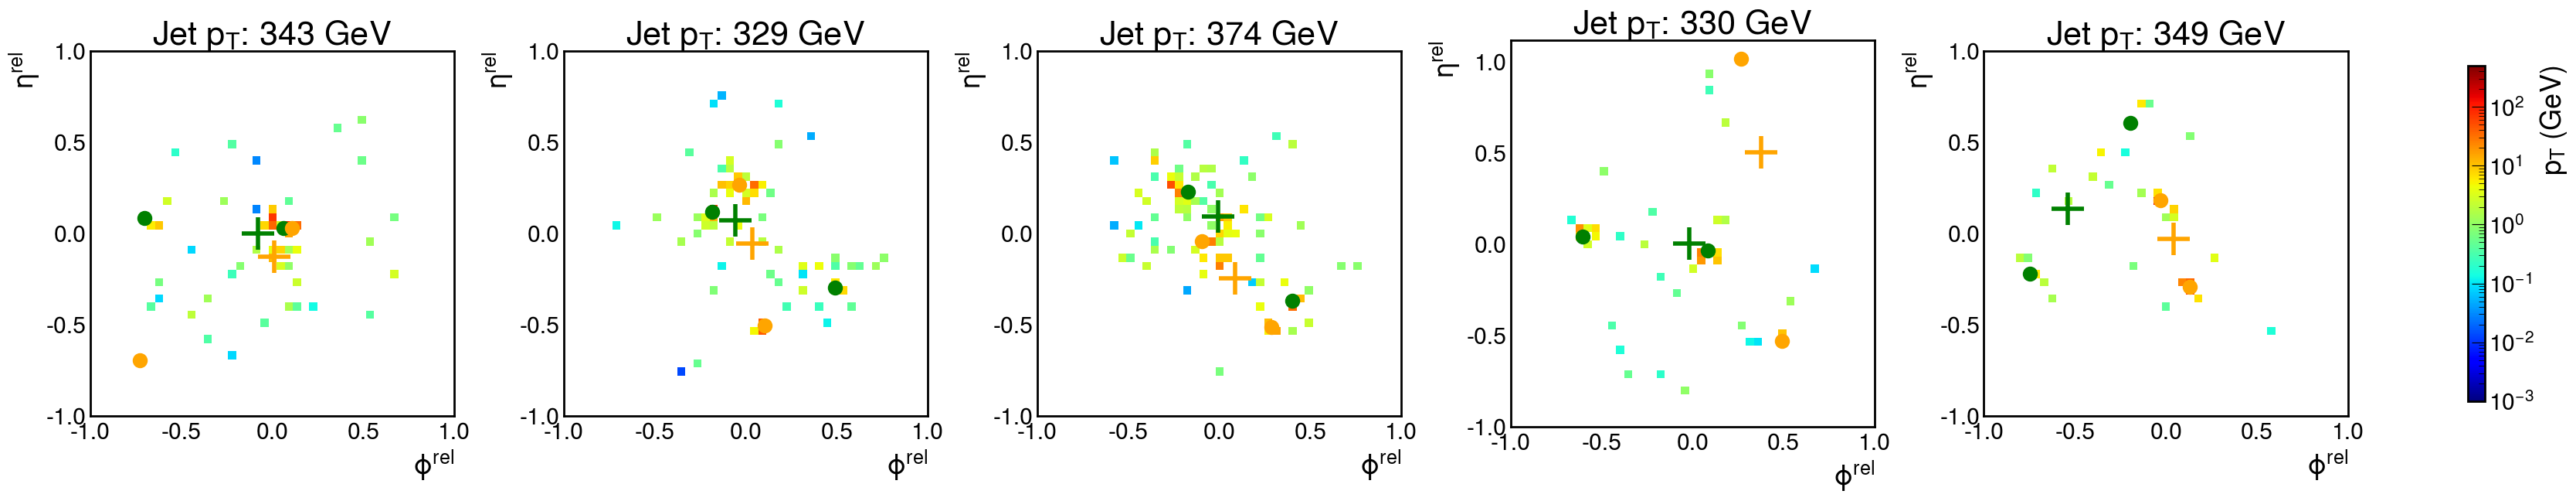

In [76]:
cm = copy(plt.cm.jet)
cm.set_under(color="white")

plt.rcParams.update({"font.size": 16})
plt.style.use(hep.style.CMS)

maxR = 1
im_size = 45


def to_image(constituents, matched_jet):
    return jetnet.utils.to_image(
        np.vstack(
            (
                constituents.eta - matched_jet.eta,
                del_phi(constituents.phi, matched_jet.phi),
                constituents.pt,
            )
        )
        .to_numpy()
        .T,
        im_size,
        maxR=maxR,
    ).T[::-1]


def plotW(ax, i, j, color, shape):
    ax.plot(
        del_phi(gen_vars["GenVVphi"][i][j], matched_jets[i].phi),
        gen_vars["GenVVeta"][i][j] - matched_jets[i].eta,
        shape,
        color=color,
        ms=30,
        mew=4,
    )


def plotq(ax, i, j, k, color, shape):
    ax.plot(
        del_phi(gen_vars["Gen4qphi"][i][j][k], matched_jets[i].phi),
        gen_vars["Gen4qeta"][i][j][k] - matched_jets[i].eta,
        shape,
        color=color,
        ms=10,
        mew=4,
    )


num_images = 5

vmin = 1e-3
vmax = 500

fig, axes = plt.subplots(1, num_images, figsize=(num_images * 8, 8), gridspec_kw={"wspace": 0.3})

for i in range(num_images):
    im = axes[i].imshow(
        to_image(matched_constituents[i], matched_jets[i]),
        cmap=cm,
        interpolation="nearest",
        extent=[-maxR, maxR, -maxR, maxR],
        norm=colors.LogNorm(vmin, vmax),
    )

    axes[i].set_title(f"Jet $p_T$: {matched_jets[i].pt:.0f} GeV")

    # plot Ws and qs
    plotW(axes[i], i, 0, "green", "+")
    plotq(axes[i], i, 0, 0, "green", "o")
    plotq(axes[i], i, 0, 1, "green", "o")
    plotW(axes[i], i, 1, "orange", "+")
    plotq(axes[i], i, 1, 0, "orange", "o")
    plotq(axes[i], i, 1, 1, "orange", "o")

    axes[i].tick_params(which="both", bottom=False, top=False, left=False, right=False)
    axes[i].set_xlabel("$\phi^{rel}$")
    axes[i].set_ylabel("$\eta^{rel}$")

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.007)
cbar.set_label("$p_T$ (GeV)")

plt.savefig(f"{plot_dir}/gen_jet_ims.pdf", bbox_inches="tight")
plt.show()


TypeError: unsupported format string passed to method.__format__

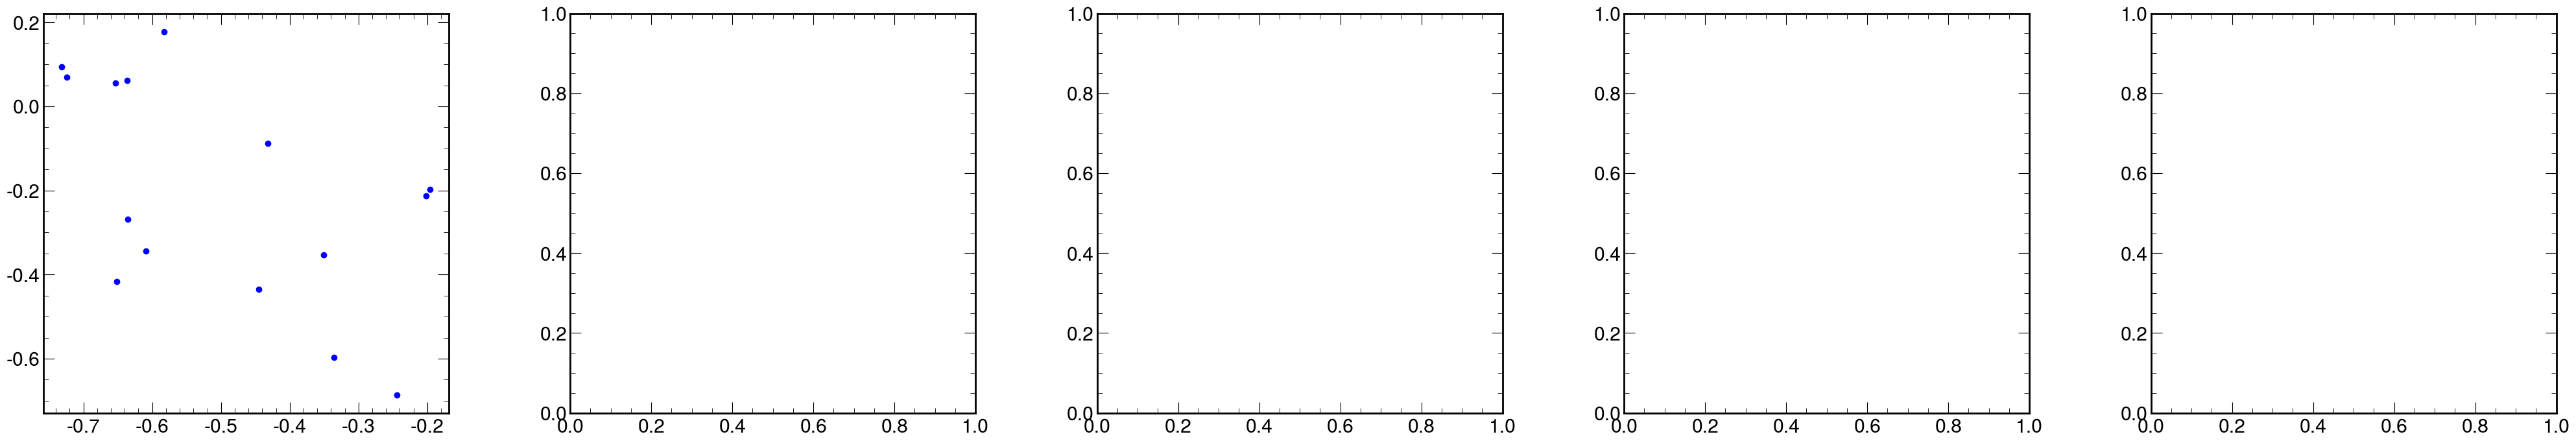

In [81]:
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 10, 8), gridspec_kw={"wspace": 0.3})

for i in range(num_images):
    colours = ["blue", "brown"]
    for j in range(2):
        consts = ca_W_subjet_constituents[i][j]
        for const in consts:
            axes[i].plot(
                del_phi(const.phi, matched_jets[i].phi),
                const.eta - matched_jets[i].eta,
                color=colours[j],
                marker="o",
            )

        axes[i].annotate(rf"Subjet {j+1} $p_T$: {ca_W_subjets[i][j].pt:.0f} GeV", (0, j*10), color=colours[j])

    axes[i].set_title(f"Jet $p_T$: {matched_jets[i].pt:.0f} GeV")

    plotW(axes[i], i, 0, "green", "+")
    plotq(axes[i], i, 0, 0, "green", "o")
    plotq(axes[i], i, 0, 1, "green", "o")
    plotW(axes[i], i, 1, "orange", "+")
    plotq(axes[i], i, 1, 0, "orange", "o")
    plotq(axes[i], i, 1, 1, "orange", "o")

    axes[i].set_xlim([-maxR, maxR])
    axes[i].set_ylim([-maxR, maxR])

    axes[i].tick_params(which="both", bottom=False, top=False, left=False, right=False)
    axes[i].set_xlabel("$\phi^{rel}$")
    axes[i].set_ylabel("$\eta^{rel}$")

plt.savefig(f"{plot_dir}/ca_W_subjets.pdf", bbox_inches="tight")
plt.show()


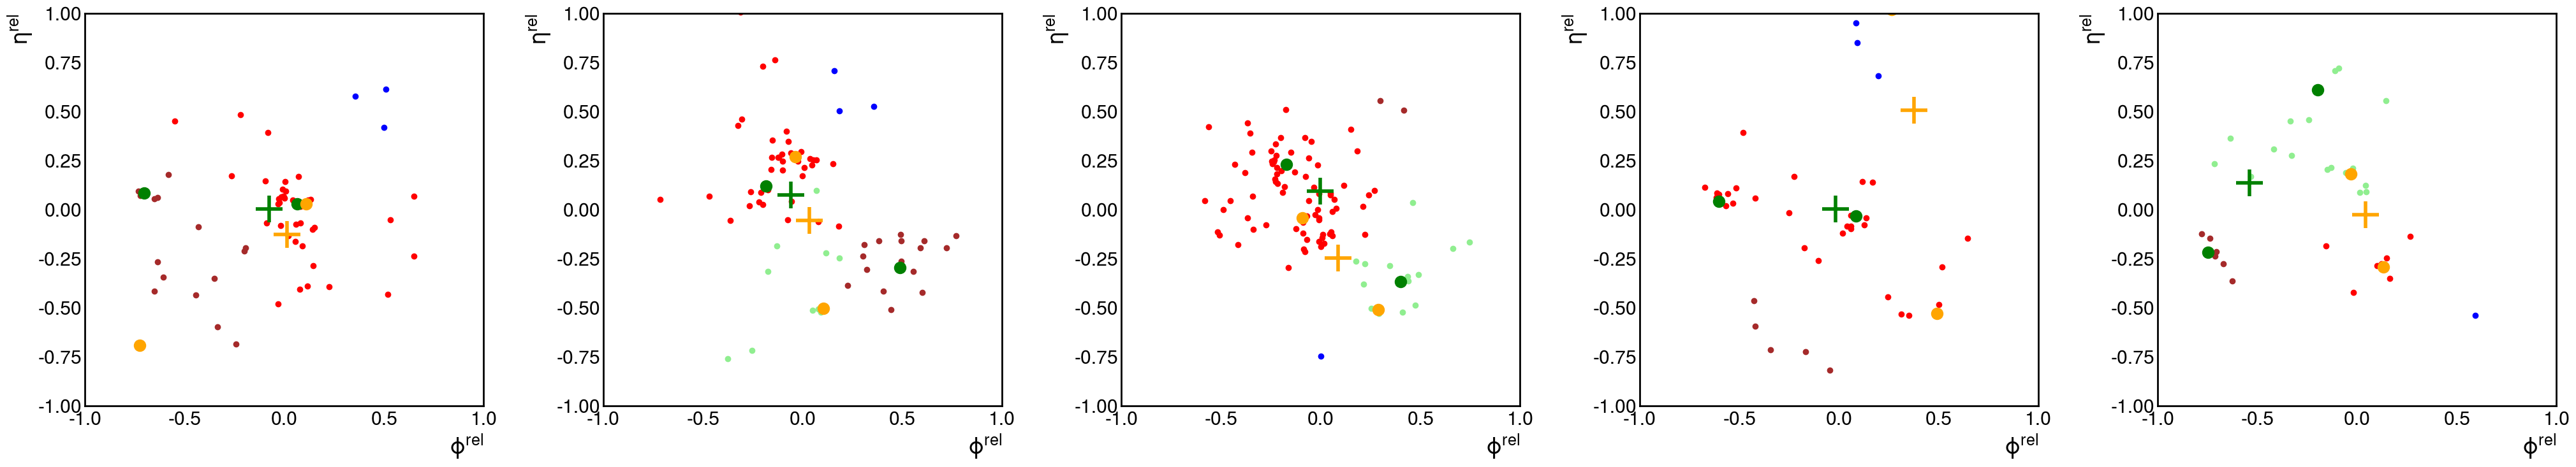

In [65]:
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 10, 8), gridspec_kw={"wspace": 0.3})

for i in range(num_images):
    colours = ["blue", "brown", "red", "lightgreen"]
    for j, consts in enumerate(ca_q_subjet_constituents[i]):
        for const in consts:
            axes[i].plot(
                del_phi(const.phi, matched_jets[i].phi),
                const.eta - matched_jets[i].eta,
                color=colours[j],
                marker="o",
            )

    plotW(axes[i], i, 0, "green", "+")
    plotq(axes[i], i, 0, 0, "green", "o")
    plotq(axes[i], i, 0, 1, "green", "o")
    plotW(axes[i], i, 1, "orange", "+")
    plotq(axes[i], i, 1, 0, "orange", "o")
    plotq(axes[i], i, 1, 1, "orange", "o")

    axes[i].set_xlim([-maxR, maxR])
    axes[i].set_ylim([-maxR, maxR])

    axes[i].tick_params(which="both", bottom=False, top=False, left=False, right=False)
    axes[i].set_xlabel("$\phi^{rel}$")
    axes[i].set_ylabel("$\eta^{rel}$")

plt.savefig(f"{plot_dir}/ca_q_subjets.pdf", bbox_inches="tight")
plt.show()


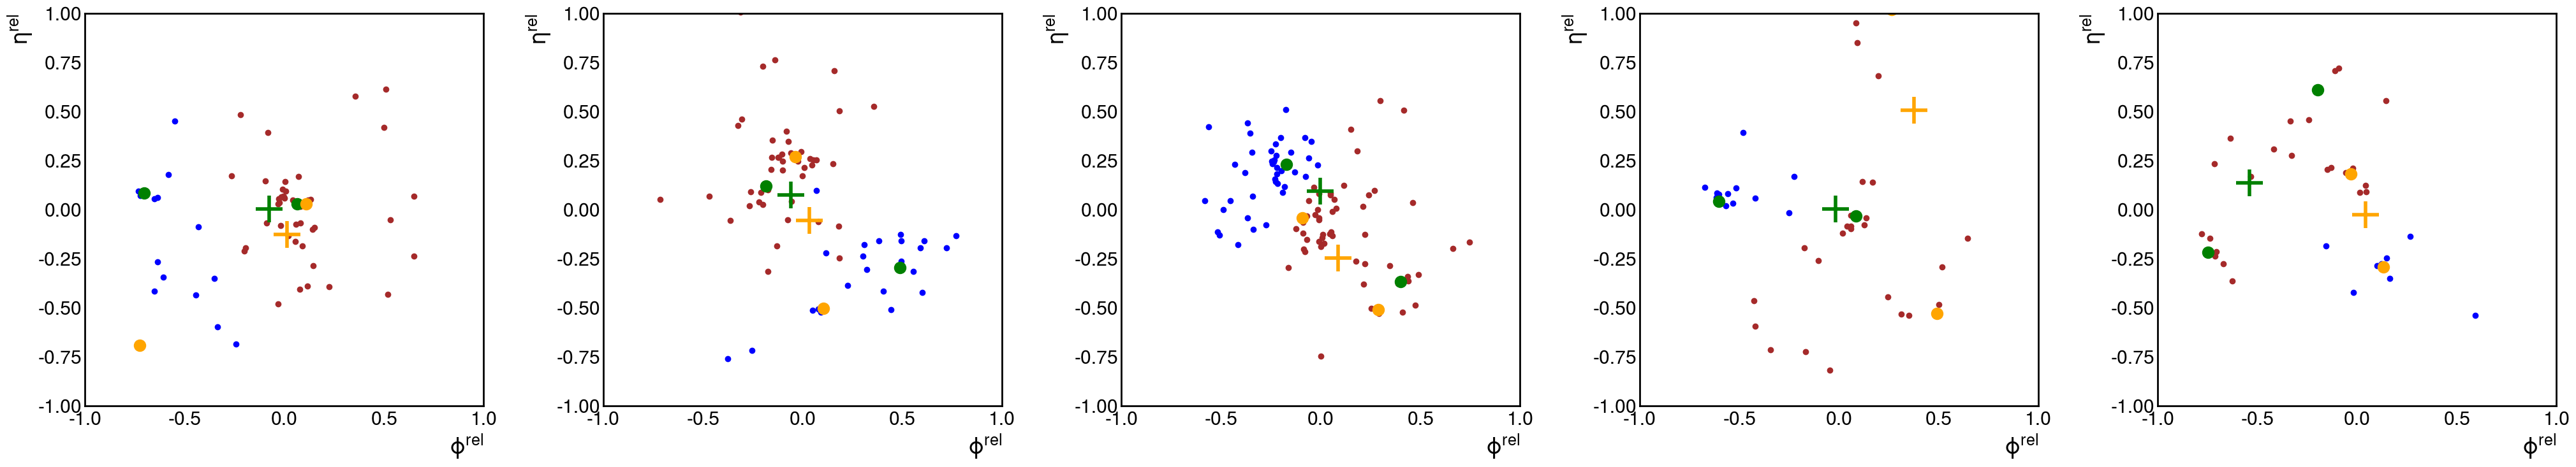

In [69]:
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 10, 8), gridspec_kw={"wspace": 0.3})

for i in range(num_images):
    colours = ["blue", "brown"]
    for j in range(2):
        consts = kt_W_subjet_constituents[i][j]
        for const in consts:
            axes[i].plot(
                del_phi(const.phi, matched_jets[i].phi),
                const.eta - matched_jets[i].eta,
                color=colours[j],
                marker="o",
            )

    plotW(axes[i], i, 0, "green", "+")
    plotq(axes[i], i, 0, 0, "green", "o")
    plotq(axes[i], i, 0, 1, "green", "o")
    plotW(axes[i], i, 1, "orange", "+")
    plotq(axes[i], i, 1, 0, "orange", "o")
    plotq(axes[i], i, 1, 1, "orange", "o")

    axes[i].set_xlim([-maxR, maxR])
    axes[i].set_ylim([-maxR, maxR])

    axes[i].tick_params(which="both", bottom=False, top=False, left=False, right=False)
    axes[i].set_xlabel("$\phi^{rel}$")
    axes[i].set_ylabel("$\eta^{rel}$")

plt.savefig(f"{plot_dir}/kt_W_subjets.pdf", bbox_inches="tight")
plt.show()


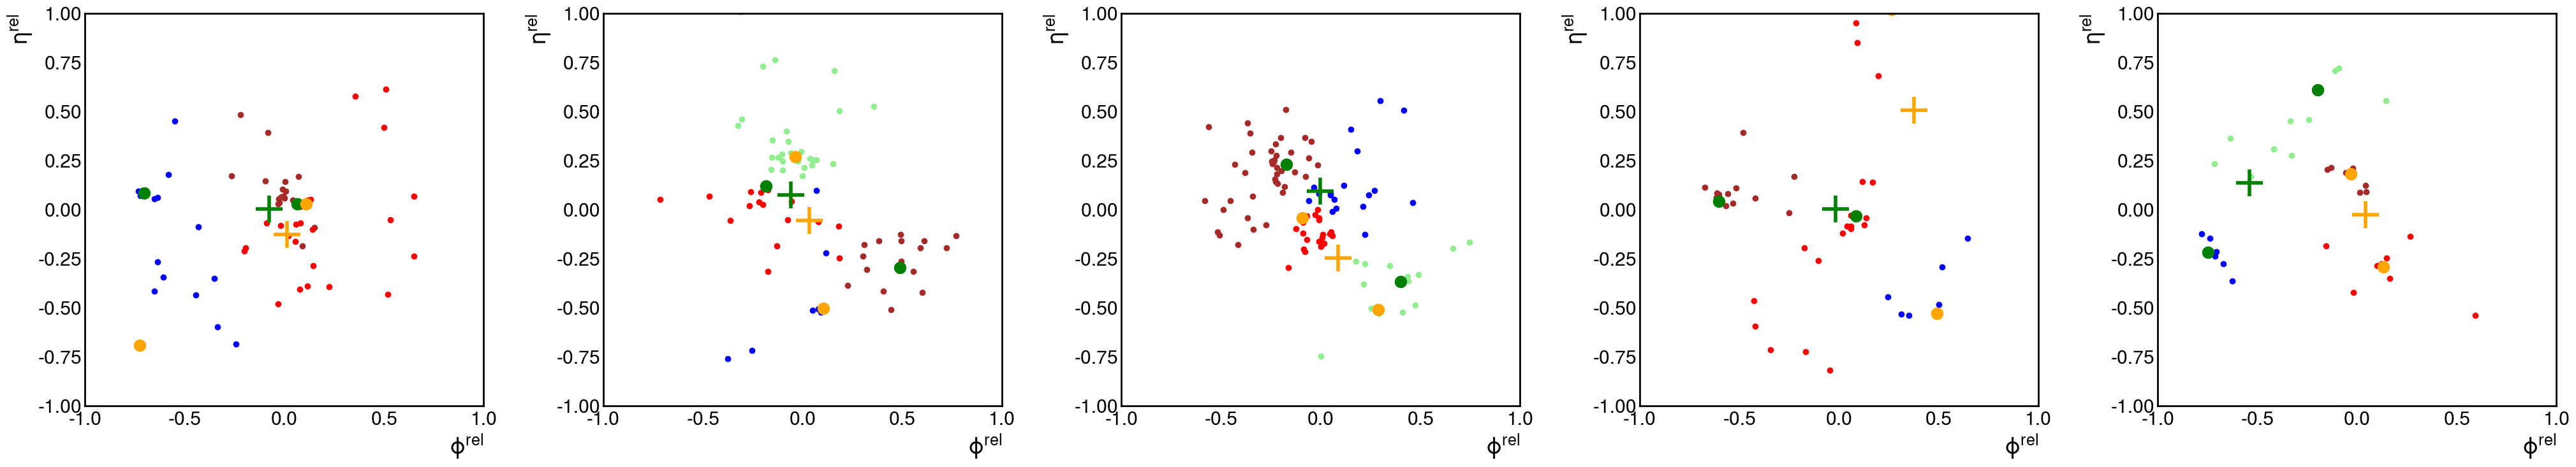

In [70]:
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 10, 8), gridspec_kw={"wspace": 0.3})

for i in range(num_images):
    colours = ["blue", "brown", "red", "lightgreen"]
    for j, consts in enumerate(kt_q_subjet_constituents[i]):
        for const in consts:
            axes[i].plot(
                del_phi(const.phi, matched_jets[i].phi),
                const.eta - matched_jets[i].eta,
                color=colours[j],
                marker="o",
            )

    plotW(axes[i], i, 0, "green", "+")
    plotq(axes[i], i, 0, 0, "green", "o")
    plotq(axes[i], i, 0, 1, "green", "o")
    plotW(axes[i], i, 1, "orange", "+")
    plotq(axes[i], i, 1, 0, "orange", "o")
    plotq(axes[i], i, 1, 1, "orange", "o")

    axes[i].set_xlim([-maxR, maxR])
    axes[i].set_ylim([-maxR, maxR])

    axes[i].tick_params(which="both", bottom=False, top=False, left=False, right=False)
    axes[i].set_xlabel("$\phi^{rel}$")
    axes[i].set_ylabel("$\eta^{rel}$")

plt.savefig(f"{plot_dir}/kt_q_subjets.pdf", bbox_inches="tight")
plt.show()
